<h2>Mount Drive

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


<h2>Import Libraries

In [2]:
import os
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import albumentations as alb

<h2>Set Paths

In [22]:
gdrive_path = r"/content/gdrive/MyDrive"
model_path = os.path.join(gdrive_path, "model_face_detection")
data_path = os.path.join(model_path, "data")

<h2>Limit GPU Memory Growth

In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

<h2>Load Images

In [5]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [6]:
images = tf.data.Dataset.list_files(os.path.join(data_path, "train", "images", "*.jpg"), shuffle=False)
images = images.map(load_image)

<h2>Visualize Images

In [7]:
image_generator = images.batch(4).as_numpy_iterator()

In [9]:
plot_images = image_generator.next()

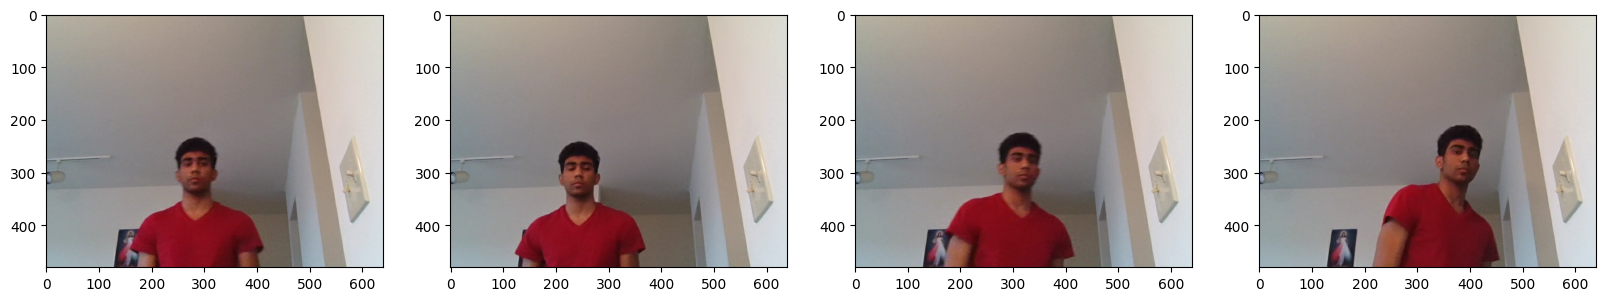

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
  ax[idx].imshow(image)
plt.show()

<h2>Data Augmentation

In [11]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format="albumentations",
                                                    label_fields=["class_labels"]))

<h2>Load a Test Image with Annotation

array([[[134, 142, 155],
        [134, 142, 155],
        [134, 141, 156],
        ...,
        [181, 180, 196],
        [181, 180, 196],
        [181, 180, 196]],

       [[134, 142, 155],
        [134, 142, 155],
        [134, 141, 156],
        ...,
        [182, 181, 197],
        [182, 181, 197],
        [181, 180, 196]],

       [[134, 141, 156],
        [134, 141, 156],
        [134, 141, 156],
        ...,
        [181, 181, 197],
        [181, 180, 196],
        [180, 179, 195]],

       ...,

       [[155, 144, 146],
        [155, 144, 146],
        [158, 145, 147],
        ...,
        [192, 178, 189],
        [192, 178, 189],
        [191, 177, 188]],

       [[154, 144, 144],
        [154, 144, 144],
        [154, 144, 144],
        ...,
        [192, 178, 189],
        [192, 178, 189],
        [191, 177, 188]],

       [[153, 143, 143],
        [153, 143, 143],
        [152, 142, 142],
        ...,
        [193, 179, 190],
        [192, 178, 189],
        [191, 177, 188]]], dtype=uint8)
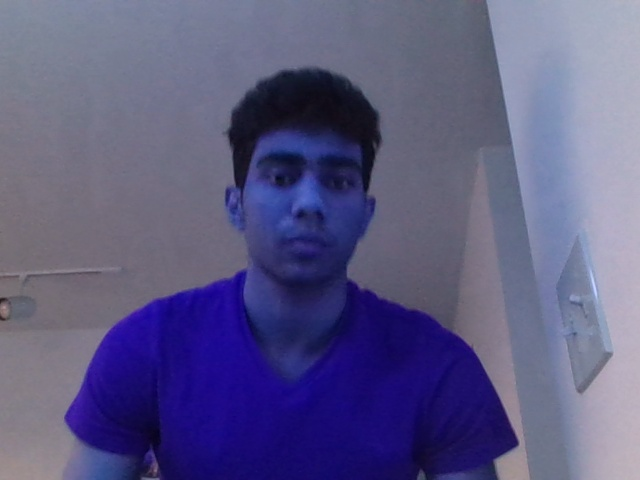

In [12]:
img = cv2.imread(os.path.join(data_path, "train", "images", "21339380-d1b7-11ee-9689-01d8b3b419dd.jpg"))
img

In [13]:
with open(os.path.join(data_path, "train", "labels", "21339380-d1b7-11ee-9689-01d8b3b419dd.json")) as f:
  label = json.load(f)

In [14]:
label["shapes"][0]["points"]

[[214.28571428571428, 87.14285714285714],
 [372.57142857142856, 279.7142857142857]]

In [15]:
coords = [0,0,0,0]
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]
coords

[214.28571428571428, 87.14285714285714, 372.57142857142856, 279.7142857142857]

In [16]:
coords = list(np.divide(coords, [640,480,640,480]))

In [17]:
coords

[0.33482142857142855,
 0.18154761904761904,
 0.5821428571428571,
 0.5827380952380953]

<h2>Apply Augmentations

In [18]:
augmented_image = augmentor(image=img, bboxes=[coords], class_labels=["face"])

In [19]:
print(type(augmented_image))
print(augmented_image.keys())
print(augmented_image["bboxes"])
print(augmented_image["class_labels"])

<class 'dict'>
dict_keys(['image', 'bboxes', 'class_labels'])
[(0.11619047619047618, 0.43174603174603177, 0.4679365079365079, 0.8596825396825397)]
['face']


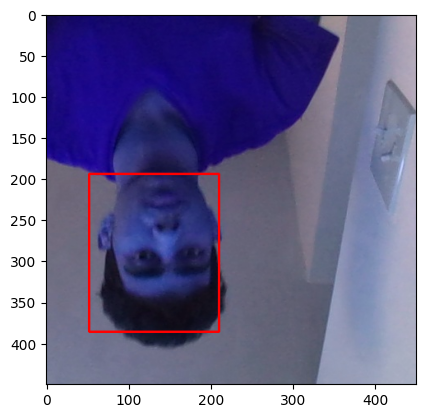

In [20]:
cv2.rectangle(augmented_image["image"],
              tuple(np.multiply(augmented_image["bboxes"][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented_image["bboxes"][0][2:], [450,450]).astype(int)),
              (255,0,0), 2)

plt.imshow(augmented_image["image"])
plt.show()

<h2>Augmentation Pipeline

In [23]:
for partition in ["train", "test", "val"]:
  for image in os.listdir(os.path.join(data_path, partition, "images")):
    img = cv2.imread(os.path.join(data_path, partition, "images", image))

    coords = [0, 0, 0.00001, 0.00001]
    label_path = os.path.join(data_path, partition, "labels", f"{image.split('.')[0]}.json")
    if os.path.exists(label_path):
      with open(label_path, "r") as f:
        label = json.load(f)

      coords[0] = label["shapes"][0]["points"][0][0]
      coords[1] = label["shapes"][0]["points"][0][1]
      coords[2] = label["shapes"][0]["points"][1][0]
      coords[3] = label["shapes"][0]["points"][1][1]
      coords = list(np.divide(coords, [640,480,640,480]))

    try:
      for x in range(60):
        augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])
        cv2.imwrite(os.path.join(model_path, "aug_data", partition, "images", f"{image.split('.')[0]}.{x}.jpg"), augmented["image"])

        annotation = {}
        annotation["image"] = image

        if os.path.exists(label_path):
          if len(augmented["bboxes"]) == 0:
            annotation["bbox"] = [0,0,0,0]
            annotation["class"] = 0
          else:
            annotation["bbox"] = augmented["bboxes"][0]
            annotation["class"] = 1
        else:
          annotation["bbox"] = [0,0,0,0]
          annotation["class"] = 0

        with open(os.path.join(model_path, "aug_data", partition, "labels", f"{image.split('.')[0]}.{x}.json"), "w") as f:
          json.dump(annotation, f)
    except Exception as e:
      print(e)